# Загрузка библиотек

In [ ]:
!pip install datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.2 MB/s eta 0:00:00


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-12-02 18:13:29--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-12-02 18:13:29--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-12-02 18:13:29--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

# Загрузка датасета

In [ ]:
import pandas as pd
import numpy as np
from numpy import array
import re
import nltk
from nltk.corpus import stopwords
import os

from datasets import load_dataset
from datasets import Dataset, DatasetDict, concatenate_datasets

from sklearn.model_selection import train_test_split

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

Stanford Sentiment Treebank(https://huggingface.co/datasets/sst2) - датасет с предложениями на английском языке из обзоров на фильмы, помеченные 0 - negative и 1 - positive.

In [ ]:
dataset = load_dataset(path='sst2')

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})

Соединяем train, validation, test в один dataset.

In [ ]:
dataset = concatenate_datasets([dataset['train'], dataset['validation'], dataset['test']])

In [ ]:
dataset

Dataset({
    features: ['idx', 'sentence', 'label'],
    num_rows: 70042
})

In [ ]:
len(dataset)

70042

In [ ]:
set(dataset['label'])

{-1, 0, 1}

Удалим label -1

In [ ]:
dataset = dataset.select(
    (
        i for i in range(len(dataset))
        if dataset[i]['label'] in [0,1]
    )
)

In [ ]:
set(dataset['label'])

{0, 1}

Загрузим стоп-слова и удалим из них негативные.

In [ ]:
stop_words = stopwords.words('english')

stop_words.remove('not')
stop_words.remove('no')

In [ ]:
def preprocess_text(sen):
    # Приводим к нижнему регистру
    sentence = sen.lower()

    # Удаляем пунктуацию и числа
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Удаляем одни символы
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Удаление нескольких пробелов
    sentence = re.sub(r'\s+', ' ', sentence)

    # Лемматизируем
    doc = nlp(sentence)
    lemmas = [token.lemma_ for token in doc]

    # Удаление стоп-слов и неалфавитных символов
    a_lemmas = [lemma for lemma in lemmas if lemma.isalpha() and lemma not in stop_words]

    return ' '.join(a_lemmas)

Посмотрим пример

In [ ]:
dataset[78]

{'idx': 78,
 'sentence': 'contains very few laughs and even less surprises ',
 'label': 0}

Разбиваем датасет в пропорции train-80%, test-20%.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['sentence'], dataset['label'], test_size=0.2, random_state=1)

Очищаем данные

In [ ]:
X_train_pr = []
X_test_pr = []

for sen in X_train:
    X_train_pr.append(preprocess_text(sen))

for sen in X_test:
    X_test_pr.append(preprocess_text(sen))

In [ ]:
X_test[:5]

['might be like trying to eat brussels sprouts . ',
 'amounts to surprisingly little ',
 'easy to like ',
 ', it still works . ',
 "of this ` we 're - doing-it-for - the-cash ' sequel "]

In [ ]:
X_test_pr[:5]

['might like try eat brussels sprout',
 'amount surprisingly little',
 'easy like',
 'still work',
 'cash sequel']

# Имплементировать и обучить классификаторы на основе:

## 1.1 Логистической регрессии + tf-idf

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

На непредобработанных отзывах:

In [ ]:
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(X_train)

clf = LogisticRegression(random_state=42, max_iter=150)
clf.fit(bow, y_train)

pred = clf.predict(vec.transform(X_test))
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      6059
           1       0.89      0.91      0.90      7586

    accuracy                           0.89     13645
   macro avg       0.89      0.88      0.89     13645
weighted avg       0.89      0.89      0.89     13645



На предобработанных отзывах:

In [ ]:
vec1 = TfidfVectorizer(ngram_range=(1, 1))
bow1 = vec1.fit_transform(X_train_pr)

clf1 = LogisticRegression(random_state=42, max_iter=150)
clf1.fit(bow1, y_train)

pred1 = clf1.predict(vec1.transform(X_test_pr))
print(classification_report(y_test, pred1))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      6059
           1       0.88      0.91      0.89      7586

    accuracy                           0.88     13645
   macro avg       0.88      0.87      0.88     13645
weighted avg       0.88      0.88      0.88     13645



Результат с непредобработанными отзывами немного лучше.

## 1.2 Усложнение. Добавить в качестве признака pos-tag в Логистическую регрессию + tf-idf

In [ ]:
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Добавляем часть речи к каждому слову

In [ ]:
def add_postag(sent):
  pos_tags = nltk.pos_tag(sent.split(' '))

  s = []
  for p in pos_tags:
    s.append(p[0] + '_' + p[1])

  return ' '.join(s)

In [ ]:
X_train_pt = list(map(add_postag,X_train_pr))
X_test_pt = list(map(add_postag,X_test_pr))

In [ ]:
X_test_pt[0]

'might_MD like_VB try_VB eat_NN brussels_NNS sprout_VBP'

In [ ]:
vec3 = TfidfVectorizer(ngram_range=(1, 1))
bow3 = vec3.fit_transform(X_train_pt)

clf3 = LogisticRegression(random_state=42, max_iter=150)
clf3.fit(bow3, y_train)

pred3 = clf3.predict(vec3.transform(X_test_pt))
print(classification_report(y_test, pred3))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86      6059
           1       0.88      0.90      0.89      7586

    accuracy                           0.88     13645
   macro avg       0.88      0.87      0.87     13645
weighted avg       0.88      0.88      0.88     13645



Результат не изменился

Добавим pos tags, как новые фичи

In [ ]:
vec4 = TfidfVectorizer(ngram_range=(1, 1))
bow4 = vec4.fit_transform(X_train_pr)

In [ ]:
arr = pd.DataFrame(bow4.toarray())

In [ ]:
arr

,0,1,2,3,4,5,6,7,8,9,...,11779,11780,11781,11782,11783,11784,11785,11786,11787,11788
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Загрузим set всех тегов

In [ ]:
nltk.download('tagsets')

[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

In [ ]:
from nltk.data import load
tagdict = load('help/tagsets/upenn_tagset.pickle')

In [ ]:
tagdict.keys()

dict_keys(['LS', 'TO', 'VBN', "''", 'WP', 'UH', 'VBG', 'JJ', 'VBZ', '--', 'VBP', 'NN', 'DT', 'PRP', ':', 'WP$', 'NNPS', 'PRP$', 'WDT', '(', ')', '.', ',', '``', '$', 'RB', 'RBR', 'RBS', 'VBD', 'IN', 'FW', 'RP', 'JJR', 'JJS', 'PDT', 'MD', 'VB', 'WRB', 'NNP', 'EX', 'NNS', 'SYM', 'CC', 'CD', 'POS'])

In [ ]:
tags = list(tagdict.keys())

In [ ]:
print(tags)

['LS', 'TO', 'VBN', "''", 'WP', 'UH', 'VBG', 'JJ', 'VBZ', '--', 'VBP', 'NN', 'DT', 'PRP', ':', 'WP$', 'NNPS', 'PRP$', 'WDT', '(', ')', '.', ',', '``', '$', 'RB', 'RBR', 'RBS', 'VBD', 'IN', 'FW', 'RP', 'JJR', 'JJS', 'PDT', 'MD', 'VB', 'WRB', 'NNP', 'EX', 'NNS', 'SYM', 'CC', 'CD', 'POS']


tags_dict_train - словарь для обучающей выборки, в котором ключ - тег, а значение - массив с числом встречаемости слов этого тега для каждого предложения.

In [ ]:
tags_dict_train = dict()
train_size = len(X_train_pr)

for t in tags:
  tags_dict_train[t] = np.zeros(train_size, int)

Считаем число встречаемости слов с определенным тегом для каждого предложения

In [ ]:
for i, sent in enumerate(X_train_pr):
  pos_tags = nltk.pos_tag(sent.split(' '))

  for p in pos_tags:
    tags_dict_train[p[1]][i] += 1

In [ ]:
tags_dict_train

{'LS': array([0, 0, 0, ..., 0, 0, 0]),
 'TO': array([0, 0, 0, ..., 0, 0, 0]),
 'VBN': array([0, 0, 0, ..., 0, 0, 0]),
 "''": array([0, 0, 0, ..., 0, 0, 0]),
 'WP': array([0, 0, 0, ..., 0, 0, 0]),
 'UH': array([0, 0, 0, ..., 0, 0, 0]),
 'VBG': array([0, 0, 0, ..., 0, 0, 0]),
 'JJ': array([1, 0, 2, ..., 1, 4, 0]),
 'VBZ': array([0, 0, 1, ..., 0, 0, 0]),
 '--': array([0, 0, 0, ..., 0, 0, 0]),
 'VBP': array([0, 0, 0, ..., 0, 0, 0]),
 'NN': array([0, 1, 2, ..., 3, 9, 3]),
 'DT': array([0, 0, 0, ..., 0, 1, 0]),
 'PRP': array([0, 0, 0, ..., 0, 0, 0]),
 ':': array([0, 0, 0, ..., 0, 0, 0]),
 'WP$': array([0, 0, 0, ..., 0, 0, 0]),
 'NNPS': array([0, 0, 0, ..., 0, 0, 0]),
 'PRP$': array([0, 0, 0, ..., 0, 0, 0]),
 'WDT': array([0, 0, 0, ..., 0, 0, 0]),
 '(': array([0, 0, 0, ..., 0, 0, 0]),
 ')': array([0, 0, 0, ..., 0, 0, 0]),
 '.': array([0, 0, 0, ..., 0, 0, 0]),
 ',': array([0, 0, 0, ..., 0, 0, 0]),
 '``': array([0, 0, 0, ..., 0, 0, 0]),
 '$': array([0, 0, 0, ..., 0, 0, 0]),
 'RB': array([1, 0, 

Добавляем tags_dict_train к document-term матрице, которая была посчитана с помощью TfidfVectorizer ранее

In [ ]:
for t in tags:
  arr[t] = tags_dict_train[t]

In [ ]:
arr

,0,1,2,3,4,5,6,7,8,9,...,MD,VB,WRB,NNP,EX,NNS,SYM,CC,CD,POS
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,2,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
54572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
54573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
54574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


Делаем one-hot encoding для новых фич

In [ ]:
result_train = pd.get_dummies(data=arr, columns=tags)

In [ ]:
result_train.columns = result_train.columns.astype(str)

Обучим модель

In [ ]:
clf4 = LogisticRegression(random_state=42, max_iter=150)
clf4.fit(result_train, y_train)

Делаем то же самое для тестовой выборки

In [ ]:
bow_test = vec4.fit_transform(X_test_pr)
arr_test = pd.DataFrame(bow_test.toarray())

tags_dict_test = dict()
test_size = len(X_test_pr)

for t in tags:
  tags_dict_test[t] = np.zeros(test_size, int)


for i, sent in enumerate(X_test_pr):
  pos_tags = nltk.pos_tag(sent.split(' '))

  for p in pos_tags:
    tags_dict_test[p[1]][i] += 1


for t in tags:
  arr_test[t] = tags_dict_train[t]

result_test = pd.get_dummies(data=arr_test, columns=tags)
result_test.columns = result_test.columns.astype(str)

Предскажем

In [ ]:
pred4 = clf4.predict(result_test)
print(classification_report(y_test, pred4))

У меня не получилось предсказать, так как каждый раз не хватало RAM(

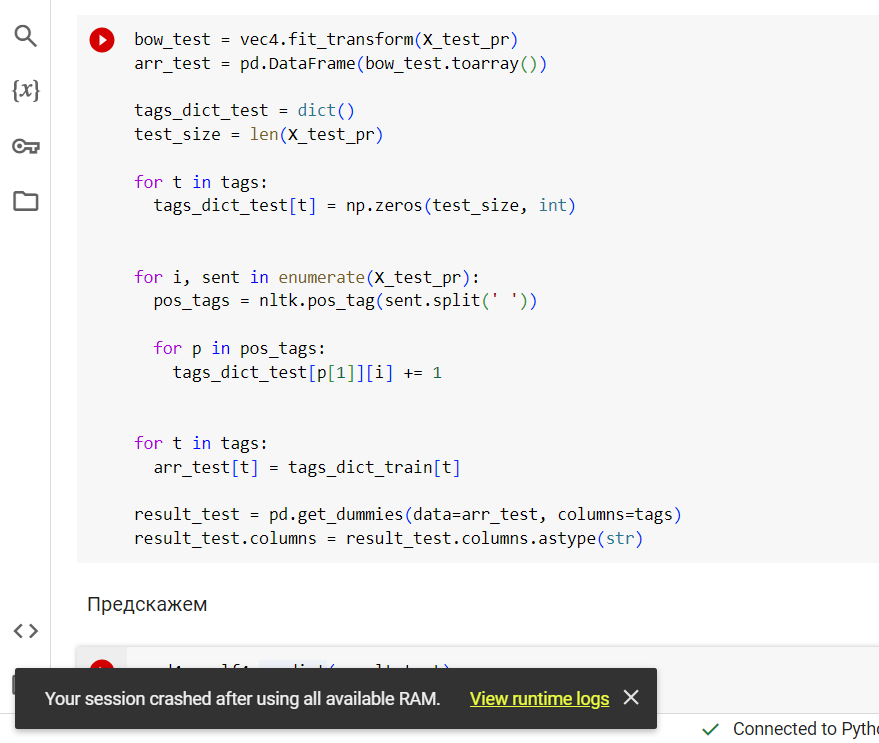

## 2.1 LSTM + предобученные векторные представления слов

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras import utils

from numpy import asarray
from numpy import zeros

In [ ]:
# Токенизация
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_prt = tokenizer.texts_to_sequences(X_train_pr)
X_test_prt = tokenizer.texts_to_sequences(X_test_pr)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# Выравним все отзывы до фиксировнной длины 300
maxlen = 300

X_train_prp = pad_sequences(X_train_prt, padding='post', maxlen=maxlen)
X_test_prp = pad_sequences(X_test_prt, padding='post', maxlen=maxlen)

In [ ]:
num_classes = 2
y_train_k = utils.to_categorical(y_train, num_classes)
y_test_k = utils.to_categorical(y_test, num_classes)

Скачиваем предобученные векторные представления слов GloVe

In [ ]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

Создаем матрицу, содержащую 300-мерные векторные представления слов GloVE для слов в нашем корпусе.

In [ ]:
embedding_matrix = zeros((vocab_size, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(14403, 300)

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size,  output_dim=300, weights=[embedding_matrix], input_length=maxlen, trainable=True)
model.add(embedding_layer)

model.add(LSTM(256, return_sequences = True, input_shape=(maxlen, 300)))
model.add(LSTM(128))
model.add(Dropout(rate = 0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Обучим модель

In [ ]:
model.fit(X_train_prp, y_train_k, batch_size=128, epochs=1, verbose=1)

427/427 [==============================] - 2017s 5s/step - loss: 0.6871 - accuracy: 0.5576


Получим предсказания

In [ ]:
predictions1 = model.predict(X_test_prp, batch_size = 32)
pred1 = np.argmax(predictions1, axis=1)

427/427 [==============================] - 253s 587ms/step


In [ ]:
y_test_arg1 = np.argmax(y_test_k, axis=1)

print(y_test_arg1.shape, pred1.shape)
print(y_test_arg1[:5], pred1[:5])

(13645,) (13645,)
[0 0 1 1 0] [1 1 1 1 1]


In [ ]:
print(classification_report(y_test_arg1, pred1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6059
           1       0.56      1.00      0.71      7586

    accuracy                           0.56     13645
   macro avg       0.28      0.50      0.36     13645
weighted avg       0.31      0.56      0.40     13645



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 2.2 Усложнение. Имплементация двунаправленного LSTM в качестве классификатора

In [ ]:
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import l1, l2
from keras.optimizers import Adam

import string
import nltk
import re

In [ ]:
def build_model():
    sentence_indices = Input(shape=(maxlen,), dtype='int32')

    embeddings = Embedding(input_dim=vocab_size, output_dim=300, weights=[embedding_matrix])(sentence_indices)

    X = Bidirectional(LSTM(units = 256))(embeddings)
    X = Dropout(rate = 0.2)(X)
    X = Bidirectional(LSTM(units = 128))(X)
    X = Dropout(rate = 0.2)(X)
    X = Dense(128, activation='relu')(X)
    X = Dense(2, activation='sigmoid')(X)

    model = Model(inputs=sentence_indices, outputs=X)
    return model

In [ ]:
model2 = build_model()
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 300, 300)          4320900   
                                                                 
 bidirectional_2 (Bidirecti  (None, 300, 512)          1140736   
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 300, 512)          0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)               656384    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 256)               0   

In [ ]:
adam = Adam(beta_1=0.9,beta_2=0.999,amsgrad=False)

model2.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

Обучим двунаправленный LSTM

In [ ]:
history2 = model2.fit(X_train_prp, y_train_k, batch_size=128, epochs=1)

427/427 [==============================] - 4608s 11s/step - loss: 0.3322 - accuracy: 0.8578


Получим предсказания

In [ ]:
predictions = model2.predict(X_test_prp, batch_size = 32)
pred = np.argmax(predictions, axis=1)

427/427 [==============================] - 480s 1s/step


In [ ]:
y_test_arg = np.argmax(y_test_k, axis=1)

print(y_test_arg.shape, pred.shape)
print(y_test_arg[:5], pred[:5])

(13645,) (13645,)
[0 0 1 1 0] [0 0 1 1 0]


In [ ]:
print(classification_report(y_test_arg, pred))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      6059
           1       0.89      0.92      0.91      7586

    accuracy                           0.89     13645
   macro avg       0.89      0.89      0.89     13645
weighted avg       0.89      0.89      0.89     13645



Двунаправленный LSTM дал результат лучше, чем стандартный LSTM

## 3.1 BERT-based модель + линейный слой

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
tokenized_train_bert = tokenizer(X_train, truncation=True)

In [ ]:
tokenized_train_bert['label'] = y_train.copy()

In [ ]:
train_tokenized_dataset = Dataset.from_dict(tokenized_train_bert)

In [ ]:
train_tokenized_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'label'],
    num_rows: 54576
})

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
tf_train_dataset = train_tokenized_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

In [ ]:
from transformers import create_optimizer
import tensorflow as tf

batch_size = 16
num_epochs = 5
batches_per_epoch = len(train_tokenized_dataset) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

Используем BERT-based модель с линейным слоем для классификации последовательностей текста.

In [ ]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
model.compile(optimizer=optimizer,metrics=['accuracy'])

Обучим BERT

In [ ]:
model.fit(x=tf_train_dataset, epochs=1)

3411/3411 [==============================] - 15526s 5s/step - loss: 0.2209 - accuracy: 0.9131


In [ ]:
x_test_tokenized_bert = [tokenizer.encode(x, truncation=True,padding=True,return_tensors="tf") for x in X_test]

In [ ]:
def get_prediction_label(input):
  prediction = model(input)
  prediction_logits = prediction[0]
  prediction_probs = tf.nn.softmax(prediction_logits,axis=1).numpy()
  return np.argmax(prediction_probs, axis=1)[0]

In [ ]:
preds_bert = [get_prediction_label(x) for x in x_test_tokenized_bert]

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, preds_bert))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      6059
           1       0.94      0.96      0.95      7586

    accuracy                           0.94     13645
   macro avg       0.94      0.94      0.94     13645
weighted avg       0.94      0.94      0.94     13645



Лучшие результаты у классификатора - BERT